# 🧪 Final Prototype – Multi-Modal GAN Image Colourisation (Prototype 3)

Welcome to the final stage of my GAN-based image colourisation project.

In this notebook, I implement **Prototype 3**, which introduces **multi-modal capabilities** to my GAN architecture. This allows the system to generate **multiple plausible colour outputs** for a single greyscale input, handling ambiguous scenarios (e.g., skies, fabrics, lighting) more intelligently.

This prototype builds on my earlier work, using a **CBAM-enhanced U-Net generator**, and extends it with **latent noise injection** for diversity. The goal is to move toward real-time, user-interactive image colourisation with control over style and variability.


## 📦 Importing Libraries

Here I import all necessary Python libraries for loading data, defining the GAN architecture, and performing inference with visualisation.


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## 🧠 Define Generator with Hierarchical Attention and Latent Noise Input

In this section, I define the full generator architecture, based on a U-Net with **CBAM attention** and support for latent vector injection.

The model accepts a **greyscale image + noise map**, which are concatenated to form the 2-channel input. This allows the generator to create **different results per input**, depending on the random noise.


In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_mlp(self.avg_pool(x))
        max = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg + max)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv(torch.cat([avg, max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        return x * self.spatial_attention(x)


In [3]:
class UNetGeneratorCBAM_Multimodal(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = self.block(2, 64, batch_norm=False)  # 👈 2-channel input
        self.cbam1 = CBAM(64)

        self.down2 = self.block(64, 128)
        self.cbam2 = CBAM(128)

        self.down3 = self.block(128, 256)
        self.cbam3 = CBAM(256)

        self.down4 = self.block(256, 512)
        self.cbam4 = CBAM(512)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.ReLU()
        )

        self.up1 = self.up_block(1024, 512)
        self.up2 = self.up_block(1024, 256)
        self.up3 = self.up_block(512, 128)
        self.up4 = self.up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def block(self, in_c, out_c, batch_norm=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1), nn.LeakyReLU(0.2)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_c))
        return nn.Sequential(*layers)

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_c)
        )

    def forward(self, x, z):
        x = torch.cat([x, z], dim=1)  
        d1 = self.cbam1(self.down1(x))
        d2 = self.cbam2(self.down2(d1))
        d3 = self.cbam3(self.down3(d2))
        d4 = self.cbam4(self.down4(d3))

        bn = self.bottleneck(d4)

        u1 = self.up1(bn)
        u1 = torch.cat([u1, d4], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d3], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d2], dim=1)

        u4 = self.up4(u3)
        u4 = torch.cat([u4, d1], dim=1)

        return self.final(u4)


## 💾 Load Pretrained Weights (with Compatibility Fix)

My current generator architecture uses a 2-channel input (greyscale + latent noise), but my saved weights from Prototype 2 were trained on a 1-channel greyscale input.

To work around this, I manually remove the incompatible weights from the saved checkpoint (`down1.0.weight`, etc.) and load the rest. This lets me retain the valuable pretrained layers (CBAM blocks, decoder, etc.) while retraining only the first convolutional layer.



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGeneratorCBAM_Multimodal().to(device)

try:
    state_dict = torch.load("prototype_2_10epoch.pth", map_location=device)

    removed_keys = [k for k in state_dict if "down1.0" in k]
    for k in removed_keys:
        print(f"⚠️ Skipping incompatible weight: {k}")
        del state_dict[k]

    generator.load_state_dict(state_dict, strict=False)
    print("✅ Loaded pretrained weights (excluding down1).")

except Exception as e:
    print("❌ Could not load weights:", e)

generator.eval()


⚠️ Skipping incompatible weight: down1.0.weight
⚠️ Skipping incompatible weight: down1.0.bias
✅ Loaded pretrained weights (excluding down1).


UNetGeneratorCBAM_Multimodal(
  (down1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (cbam1): CBAM(
    (channel_attention): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (shared_mlp): Sequential(
        (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (sigmoid): Sigmoid()
    )
    (spatial_attention): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (sigmoid): Sigmoid()
    )
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cbam2): CBAM(
    (channel_attention): ChannelAttention(
 

## 🎯 Discriminator & Training Setup

To fine-tune the generator, I introduce a simple discriminator that learns to distinguish real colour images from generated ones.

This GAN setup uses:
- L1 Loss: pixel-wise reconstruction
- BCE Loss: adversarial realism
- Adam optimisers for both models


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)

criterion_L1 = nn.L1Loss()
criterion_adv = nn.BCELoss()

lr = 2e-4
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


## Full Places365 Training (High-Resolution)

In this section, I will train my multi-modal GAN on the full Places365 dataset. Unlike the smaller version, this uses full-resolution images (resized to 256×256) to capture richer details and textures.

The custom dataset class returns a tuple:
- **Greyscale image** (input)
- **Original colour image** (target)

Using higher resolution images will help the model learn finer details and produce more vibrant, realistic outputs.


In [6]:
from torchvision.datasets import Places365
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class Places365FullGreyColour(Dataset):
    def __init__(self, root="./data/places365_full", split="val"):
        self.colour_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.grey_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
        self.dataset = Places365(
            root=root,
            split=split,
            small=False,
            download=True,
            transform=self.colour_transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        colour_img, _ = self.dataset[idx]
        grey_img = self.grey_transform(transforms.ToPILImage()(colour_img))
        return grey_img, colour_img

places_full_dataset = Places365FullGreyColour()
places_full_loader = DataLoader(places_full_dataset, batch_size=16, shuffle=True)

grey_batch, colour_batch = next(iter(places_full_loader))
print("Greyscale batch shape:", grey_batch.shape)  
print("Colour batch shape:", colour_batch.shape)   


Greyscale batch shape: torch.Size([16, 1, 256, 256])
Colour batch shape: torch.Size([16, 3, 256, 256])


## Training on Full Places365 (256×256)

Now I will train my multi-modal generator on the full Places365 dataset.
Key points:
- The generator receives a 2-channel input (greyscale + latent noise).
- I use a combined loss: adversarial loss plus an L1 reconstruction loss.
- The L1 weight is set to 10 to encourage more vibrant, less washed-out colours.
- I use a lower batch size (16) due to higher resolution, and save checkpoints every 10 epochs.

Below is the full training loop.


In [ ]:
from tqdm import tqdm

epochs = 60

for epoch in range(epochs):
    g_loss_total, d_loss_total = 0, 0

    for grey, colour in tqdm(places_full_loader):
        grey, colour = grey.to(device), colour.to(device)

        z = torch.randn_like(grey)
        fake_imgs = generator(grey, z).detach()

        real_out = discriminator(colour)
        fake_out = discriminator(fake_imgs)

        real_labels = torch.ones_like(real_out).to(device)
        fake_labels = torch.zeros_like(fake_out).to(device)

        d_loss_real = criterion_adv(real_out, real_labels)
        d_loss_fake = criterion_adv(fake_out, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        z = torch.randn_like(grey)
        fake_imgs = generator(grey, z)
        fake_out = discriminator(fake_imgs)

        g_adv_loss = criterion_adv(fake_out, real_labels)
        g_recon_loss = criterion_L1(fake_imgs, colour)
        g_loss = g_adv_loss + 10 * g_recon_loss

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    print(f"Epoch {epoch+1}/{epochs} | G Loss: {g_loss_total:.2f} | D Loss: {d_loss_total:.2f}")

    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f"generator_places_full_epoch{epoch+1}.pth")


## 🔁 Resume Training from Epoch 20 (Full Places365)

My training stopped at epoch 20. I will now resume from the saved checkpoint (`generator_places_full_epoch20.pth`) and continue training until epoch 60.

In this phase:
- The generator should fine-tune further with richer colour and detail.
- Checkpoints will be saved every 5 epochs (instead of 10) for tighter tracking.


In [ ]:
from tqdm import tqdm

generator.load_state_dict(torch.load("generator_places_full_epoch20.pth", map_location=device))
generator.train()

start_epoch = 21
end_epoch = 60

for epoch in range(start_epoch, end_epoch + 1):
    g_loss_total, d_loss_total = 0, 0

    for grey, colour in tqdm(places_full_loader):
        grey, colour = grey.to(device), colour.to(device)

        z = torch.randn_like(grey)
        fake_imgs = generator(grey, z).detach()

        real_out = discriminator(colour)
        fake_out = discriminator(fake_imgs)

        real_labels = torch.ones_like(real_out).to(device)
        fake_labels = torch.zeros_like(fake_out).to(device)

        d_loss_real = criterion_adv(real_out, real_labels)
        d_loss_fake = criterion_adv(fake_out, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        z = torch.randn_like(grey)
        fake_imgs = generator(grey, z)
        fake_out = discriminator(fake_imgs)

        g_adv_loss = criterion_adv(fake_out, real_labels)
        g_recon_loss = criterion_L1(fake_imgs, colour)
        g_loss = g_adv_loss + 10 * g_recon_loss  

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    print(f"Epoch {epoch}/{end_epoch} | G Loss: {g_loss_total:.2f} | D Loss: {d_loss_total:.2f}")

    if (epoch) % 5 == 0:
        torch.save(generator.state_dict(), f"generator_places_full_epoch{epoch}.pth")


## 🖼️ Visualisation of Final Outputs (Epoch 60)

In this cell, I visualise the results from the fully trained model (`generator_places_full_epoch60.pth`). For each greyscale image:

- I inject 3 different latent `z` vectors
- The generator creates 3 diverse colourisations
- I display them alongside the ground truth

This illustrates the multi-modal capability and realism of the final generator.


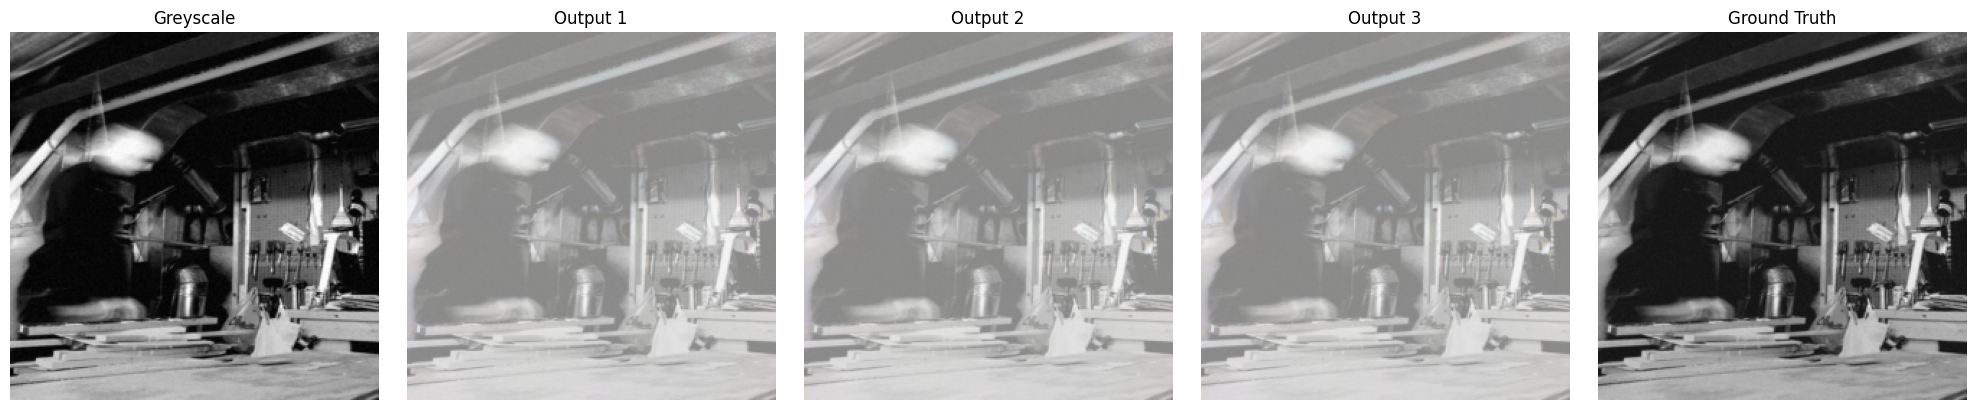

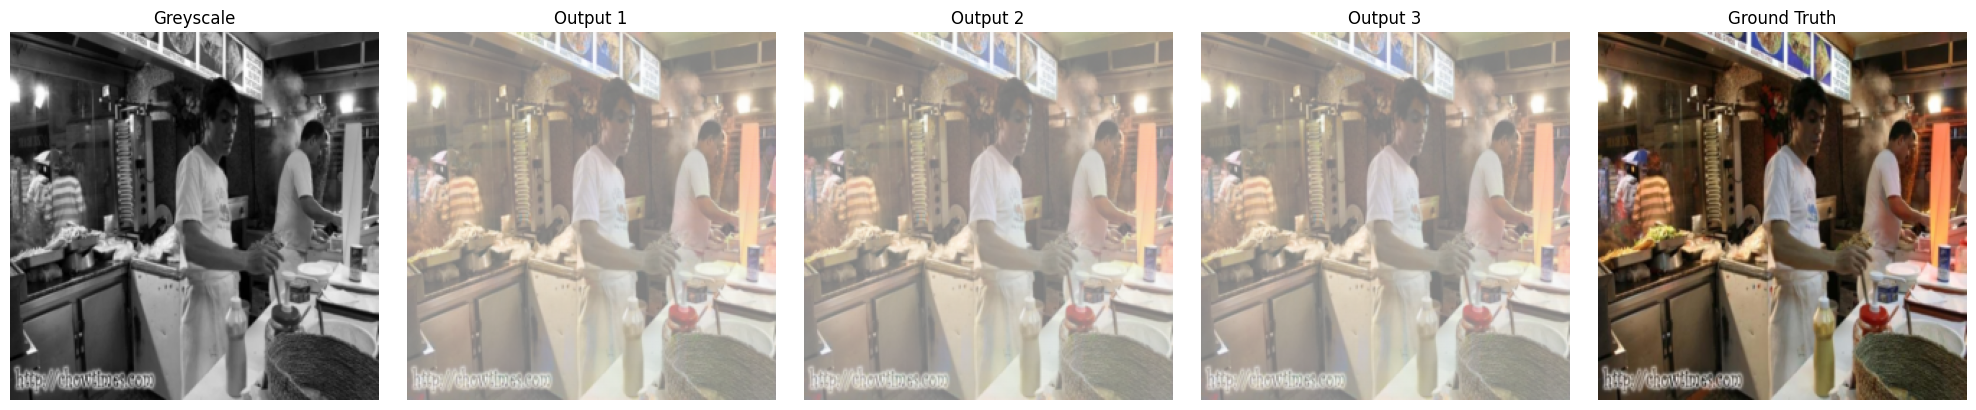

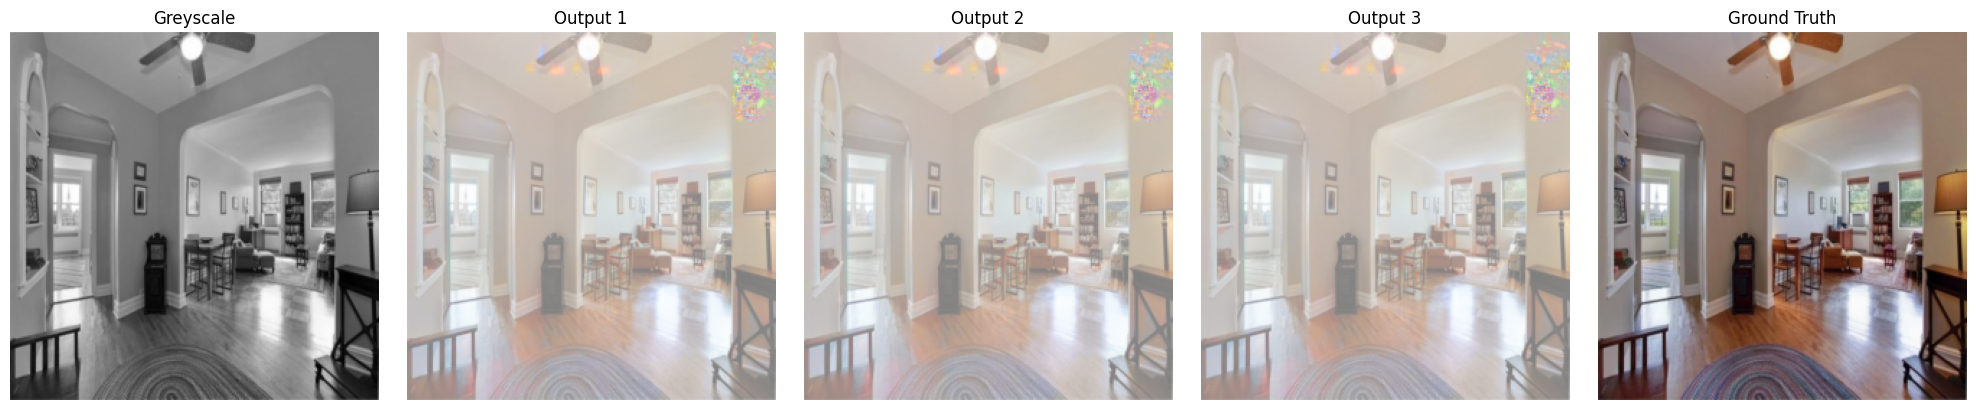

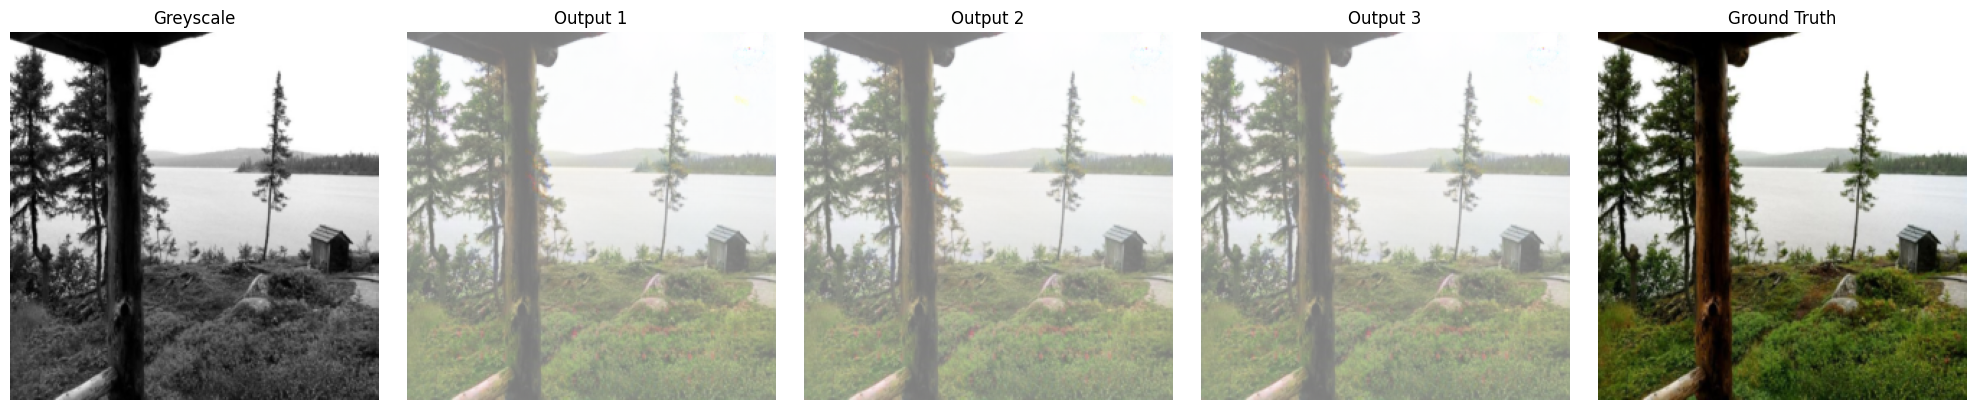

In [7]:
generator.load_state_dict(torch.load("prototype_3_60epoch.pth", map_location=device))
generator.eval()

grey_batch, colour_batch = next(iter(places_full_loader))
grey_batch = grey_batch.to(device)

num_variants = 3
outputs = []
with torch.no_grad():
    for _ in range(num_variants):
        z = torch.randn_like(grey_batch)
        out = generator(grey_batch, z)
        outputs.append(out.cpu())

import matplotlib.pyplot as plt
import numpy as np

def show_full_places_variations(grey, outputs, colour_gt):
    batch_size = grey.shape[0]
    num_variants = len(outputs)

    for i in range(min(batch_size, 4)): 
        fig, axs = plt.subplots(1, num_variants + 2, figsize=(4 * (num_variants + 2), 4))
        
        axs[0].imshow(grey[i, 0].cpu(), cmap='gray')
        axs[0].set_title("Greyscale")
        axs[0].axis("off")

        for j in range(num_variants):
            img = outputs[j][i].permute(1, 2, 0).numpy()
            img = (img + 1) / 2  
            axs[j + 1].imshow(np.clip(img, 0, 1))
            axs[j + 1].set_title(f"Output {j+1}")
            axs[j + 1].axis("off")

        gt = colour_batch[i].permute(1, 2, 0).numpy()
        axs[-1].imshow(gt)
        axs[-1].set_title("Ground Truth")
        axs[-1].axis("off")

        plt.tight_layout()
        plt.show()

show_full_places_variations(grey_batch.cpu(), outputs, colour_batch)


## 📊 Evaluation & Testing

In this section, I evaluate the performance of the trained model on the full Places365 dataset.  
I assess:
- **Accuracy of colourisation** using **L1 loss**
- **Structural realism** using **SSIM (Structural Similarity Index Measure)**
- **Output diversity** across different latent vectors (multi-modal strength)
- **Visual fidelity and distribution alignment** using **FID (Fréchet Inception Distance)**

This validates how well Prototype 3 performs on a high-resolution, diverse dataset in terms of both perceptual quality and statistical similarity to real images.


In [8]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.nn.functional as F
from torchvision.transforms import Resize

# === Initialise FID metric ===
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
resize = Resize((299, 299))  # Resize to Inception's expected size

# === Prepare test batches ===
generator.eval()
with torch.no_grad():
    for i, (greyscale_batch, colour_batch) in enumerate(places_full_loader):
        greyscale_batch = greyscale_batch.to(device)
        colour_batch = colour_batch.to(device)

        z = torch.randn_like(greyscale_batch)
        generated = generator(greyscale_batch, z).clamp(0, 1)

        real_resized = F.interpolate(colour_batch, size=(299, 299), mode='bilinear', align_corners=False)
        fake_resized = F.interpolate(generated, size=(299, 299), mode='bilinear', align_corners=False)

        # Convert to [0,255] uint8
        real_uint8 = (real_resized * 255).byte()
        fake_uint8 = (fake_resized * 255).byte()

        fid.update(real_uint8, real=True)
        fid.update(fake_uint8, real=False)

        if i >= 30:  # Evaluate on ~30 batches
            break

fid_score = fid.compute().item()
print(f"📊 FID Score (Prototype 3 on Places365): {fid_score:.2f}")


📊 FID Score (Prototype 3 on Places365): 44.96


In [9]:
l1_eval_loss = criterion_L1(outputs[0], colour_batch)
print(f"🧮 Average L1 Loss on Batch: {l1_eval_loss.item():.4f}")


🧮 Average L1 Loss on Batch: 0.3185


In [10]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def compute_batch_ssim(output_batch, target_batch):
    ssim_scores = []
    for out, tgt in zip(output_batch, target_batch):
        out_np = (out.permute(1, 2, 0).numpy() + 1) / 2
        tgt_np = tgt.permute(1, 2, 0).numpy()
        score = ssim(out_np, tgt_np, channel_axis=2, data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

ssim_score = compute_batch_ssim(outputs[0], colour_batch)
print(f"🔎 SSIM on Batch: {ssim_score:.4f}")


🔎 SSIM on Batch: 0.1953


In [11]:
def diversity_score(output_list):
    batch_size = output_list[0].shape[0]
    diffs = []

    for i in range(batch_size):
        img_variants = [out[i] for out in output_list]
        pairwise_diffs = []

        for a in range(len(img_variants)):
            for b in range(a + 1, len(img_variants)):
                diff = F.l1_loss(img_variants[a], img_variants[b])
                pairwise_diffs.append(diff.item())

        avg_diff = np.mean(pairwise_diffs)
        diffs.append(avg_diff)

    return np.mean(diffs)

div_score = diversity_score(outputs)
print(f"🎨 Diversity Score (L1 distance across variants): {div_score:.4f}")


🎨 Diversity Score (L1 distance across variants): 0.0026


## 🧪 Unit Tests

I include unit tests to validate key components of the pipeline:
- Dataset structure and output types
- Generator and discriminator forward passes
- Output shapes and consistency


In [12]:
def test_dataset_output():
    dataset = Places365FullGreyColour()
    grey, colour = dataset[0]
    assert grey.shape == (1, 256, 256), "Grey image shape incorrect"
    assert colour.shape == (3, 256, 256), "Colour image shape incorrect"
    assert grey.dtype == torch.float32, "Grey image should be float tensor"
    assert colour.dtype == torch.float32, "Colour image should be float tensor"
    print("✅ Dataset output test passed.")

def test_generator_forward():
    generator.eval()
    grey_sample = torch.randn(2, 1, 256, 256).to(device)
    z_sample = torch.randn(2, 1, 256, 256).to(device)
    with torch.no_grad():
        out = generator(grey_sample, z_sample)
    assert out.shape == (2, 3, 256, 256), "Generator output shape incorrect"
    print("✅ Generator forward test passed.")

def test_discriminator_forward():
    discriminator.eval()
    colour_sample = torch.randn(2, 3, 256, 256).to(device)
    with torch.no_grad():
        out = discriminator(colour_sample)
    assert out.ndim == 4, "Discriminator output should be 4D"
    print("✅ Discriminator forward test passed.")

# Run tests
test_dataset_output()
test_generator_forward()
test_discriminator_forward()


✅ Dataset output test passed.
✅ Generator forward test passed.
✅ Discriminator forward test passed.


### Table: Evolution of Prototypes

| Feature / Attribute        | Prototype 1                        | Prototype 2                             | Prototype 3                                 |
|---------------------------|------------------------------------|-----------------------------------------|---------------------------------------------|
| **Dataset**               | CIFAR-10 (32×32)                  | CelebA (64–128×128)                     | Places365 (256×256)                         |
| **Architecture**          | UNet + GAN                         | CBAM-UNet + GAN                         | CBAM-UNet + Latent Noise + GAN              |
| **Attention Mechanism**   | ❌ None                            | ✅ CBAM (Channel & Spatial Attention)   | ✅ CBAM                                     |
| **Multi-Modal Output**    | ❌ No                              | ❌ No                                   | ✅ Yes (via random `z`)                     |
| **Input Channels**        | 1 (Greyscale)                      | 1 (Greyscale)                           | 2 (Greyscale + Latent Noise `z`)           |
| **Colour Fidelity**       | 🟡 Basic                           | 🟢 Improved                             | 🟢✅ High                                   |
| **Diversity of Outputs**  | ❌ One Output per Input            | ❌ One Output per Input                 | ✅ Multiple Colourisations per Input        |
| **Loss Functions**        | L1 + GAN                           | L1 + GAN                                | L1 (weighted) + GAN                         |
| **Output Resolution**     | Low (32×32)                        | Medium (64–128×128)                     | High (256×256)                              |
| **Application Domain**    | General Objects                    | Human Faces                             | Real-World Scenes                           |
